In [1]:
# Import Libraries
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Define audio files
speech_audio = 'AudioWAV'

In [4]:
# Function to extract features
def extract_features(file_path):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path, sr=None)
    
    # Extract MFCCs (13 coefficients is common)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    
    # Take the mean of the MFCCs over time (flatten to 1D array)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    return mfccs_mean

In [5]:
# Define an empty list to store features and labels
features = []

# Loop over each file in the directory
for file_name in os.listdir(speech_audio):
    if file_name.endswith('.wav'):  # Adjust if your audio files have a different extension
        file_path = os.path.join(speech_audio, file_name)
        
        # Extract features and assume the emotion label is encoded in the file name
        mfccs_mean = extract_features(file_path)
        
        # Example: Parse label from the filename (e.g., "1001_WSI_SAD_XX.wav" -> "SAD")
        label = file_name.split('_')[2]
        
        # Append features and label
        features.append([mfccs_mean, label])

# Convert to DataFrame
df = pd.DataFrame(features, columns=['Features', 'Label'])

# Expand feature columns for model compatibility
features_df = pd.DataFrame(df['Features'].to_list())
features_df['Label'] = df['Label']
print(features_df.head())

            0           1          2          3          4          5  \
0 -306.027405   92.670235   8.491312  23.965403   7.477992  -5.759456   
1 -346.399628   95.839119  10.516282  31.619215  15.872088  -6.845447   
2 -321.420258   94.760910   8.155396  23.323240  11.719156  -7.116332   
3 -303.303741   92.528893   4.231232  27.970133  10.869824 -11.878345   
4 -335.495911  100.393311   9.384935  30.160906  11.466775  -3.333670   

           6         7         8          9        10        11        12  \
0 -11.883089 -9.676736 -3.996747 -13.352564  0.408197 -9.709486 -6.127125   
1  -6.629935 -4.978727 -5.310654 -10.283518 -2.534367 -7.255390 -6.153906   
2  -8.534803 -4.996966 -4.994400 -13.706510 -3.357414 -8.454173 -6.561942   
3 -10.095112 -7.149731 -7.651760 -17.085901 -0.201025 -8.867324 -9.357766   
4  -8.350987 -9.757346 -6.079328 -12.109531  1.537681 -9.795646 -3.472060   

  Label  
0   ANG  
1   DIS  
2   FEA  
3   HAP  
4   NEU  


In [6]:
# Step 1: Encode the labels
# Initialize the LabelEncoder, which will convert categorical labels (e.g., emotions like 'Happy', 'Sad') into numeric codes.
le = LabelEncoder()

# Apply the LabelEncoder to the 'Label' column in the features DataFrame.
features_df['Label'] = le.fit_transform(features_df['Label'])

# Step 2: Separate features and labels
X = features_df.drop(columns=['Label']).values  # Convert to NumPy array for model compatibility

# Extract the target variable (y) as a separate array containing only the encoded labels.
y = features_df['Label'].values  # Convert to NumPy array for model compatibility

# Step 3: Set up the train-test split
# test_size=0.2 means 20% of the data will be reserved for testing, while 80% will be used for training.
# random_state=42 ensures reproducibility of the split, so that the same split is generated each time the code runs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Define the neural network architecture for Speech Emotion Recognition (SER)
class SERModel(nn.Module):
    
    # The initializer (__init__) sets up the layers and operations for the network.
    def __init__(self, input_size, num_classes):
        super(SERModel, self).__init__()
        
        # Takes 'input_size' as input features and maps to 128 neurons.
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    # Define the forward pass, which outlines how data flows through the model layers.
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        # Return the output of the network.
        return x



In [8]:
# Convert numpy arrays to PyTorch tensors with appropriate data types
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert training features to float tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long)     # Convert training labels to long tensor for classification
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)    # Convert test features to float tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.long)       # Convert test labels to long tensor for classification

# Create TensorDataset for training and testing data to handle features and labels together
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing during training and testing
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # Shuffle training data
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)   # Do not shuffle test data



In [9]:
# Model parameters
input_size = X_train.shape[1]
num_classes = len(le.classes_)

# Initialize the model, loss function, and optimizer
model = SERModel(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Set the model to evaluation mode to disable dropout layers
model.eval()

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    correct = 0  # Initialize counter for correctly predicted samples
    total = 0    # Initialize counter for total samples
    
    # Loop through each batch in the test DataLoader
    for X_batch, y_batch in test_loader:
        # Pass the batch of features through the model to get predictions
        outputs = model(X_batch)
        
        # Get the predicted class by selecting the index with the maximum score for each sample
        _, predicted = torch.max(outputs, 1)
        
        # Update the total count of samples
        total += y_batch.size(0)
        
        # Count correct predictions by comparing with true labels and summing matches
        correct += (predicted == y_batch).sum().item()
    
    # Calculate accuracy as a percentage of correct predictions out of total samples
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Epoch [1/20], Loss: 1.8430
Epoch [2/20], Loss: 1.6441
Epoch [3/20], Loss: 1.7712
Epoch [4/20], Loss: 1.7662
Epoch [5/20], Loss: 1.9137
Epoch [6/20], Loss: 2.9081
Epoch [7/20], Loss: 1.7276
Epoch [8/20], Loss: 1.9568
Epoch [9/20], Loss: 1.7363
Epoch [10/20], Loss: 1.5186
Epoch [11/20], Loss: 1.7017
Epoch [12/20], Loss: 1.3828
Epoch [13/20], Loss: 0.9480
Epoch [14/20], Loss: 1.7364
Epoch [15/20], Loss: 1.9527
Epoch [16/20], Loss: 0.9357
Epoch [17/20], Loss: 1.2971
Epoch [18/20], Loss: 1.0301
Epoch [19/20], Loss: 4.2055
Epoch [20/20], Loss: 1.9952
Test Accuracy: 35.73%


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Placeholder lists to store true and predicted labels
y_true = []
y_pred = []

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    for X_batch, y_batch in train_loader: 
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        # Append true and predicted labels
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [11]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

         ANG       0.52      0.59      0.56      1036
         DIS       0.24      0.01      0.01      1002
         FEA       0.25      0.00      0.01      1032
         HAP       0.26      0.27      0.27      1011
         NEU       0.24      0.23      0.23       863
         SAD       0.31      0.87      0.46      1009

    accuracy                           0.33      5953
   macro avg       0.30      0.33      0.26      5953
weighted avg       0.31      0.33      0.26      5953



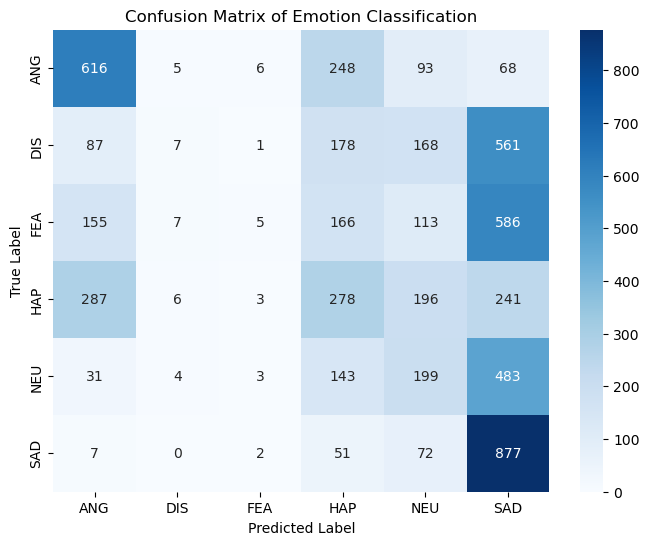

In [12]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Emotion Classification")
plt.show()